In [26]:
import numpy as np
import scipy.stats as sstats
import RNG.Distributions as rngd
import matplotlib.pyplot as plt
import EventByEvent.DiscreteSim as ds
import EventByEvent.VarianceReduction as vr

### Exercise 5 Task 1):

We use the Crude Monte Carlo method on 100 samples and get a value of approx. 1.69-1.7

We are able to get means far away from the true mean 1.718....

In [27]:
U1 = np.random.uniform(0,1,100)
X = np.exp(U1)
print(np.mean(X))

1.743093698949914


### Exercise 5 Task 2)

All of the means we've observed have the first three numbers of 1.71

In [28]:
X_prime = np.exp(1-U1)
Y = (X+X_prime)/2
print(np.mean(Y))

1.7130213350747305


### Exercise 5 Task 3)


We have a Y whose mean we know, and we would like to be able to estimate the mean of X, which we do not.

We set $Z = X + c \times (Y - \mu_{y})$, such that $E[Z] = E[X] + C*(0) = E[X]$

But we choose a c, to minimize the variance of Z:

$Var[Z] = Var[X] + c^{2}Var[Y] + 2cCov(X,y)$

Which gives us

$c = \frac{Cov(x,y)}{Var[Y]}$ which in total gives us that the variance of Z to be:

$Var[Z] = Var[X] - \frac{Cov(x,y)^2}{Var[Y]} \leq Var[X]$

Where $Y ~ U(0,1)$ in our case


In [29]:
c = -1*np.cov(X,U1)[1,0]/np.var(U1)
Z = X + c*(U1 - 1/2)
print(np.mean(Z))

1.7125271658669194


# Exercise 5 Task 4)


In [30]:
Wi = np.zeros(10)
for i in range(10):
    Wi += np.exp(i/10+ U1[i*10:(i+1)*10]/10)
Wi /= 10
print(Wi.mean())

1.7204005214407616


Exercise 5 Task 5)

We use the assumption that our proportions follow a standard normal distribution to do control variate method directly on these.

We let $Z = X + c(\bar{Y} -\mu_{Y})$

Here X = proportion of blocked customers and $\bar{Y}$  is the empirical mean arrival time.

We have that $\mu_{\bar{Y}} = E[\bar{Y}] = E[Y]$ for large numbers of sample due to the law of large numbers.
An assumption here is of course that the different runs are independent.



Blocked C.I: [0.11795835945743974, 0.12742164054256028]	 Nr accepted in first run: 8787


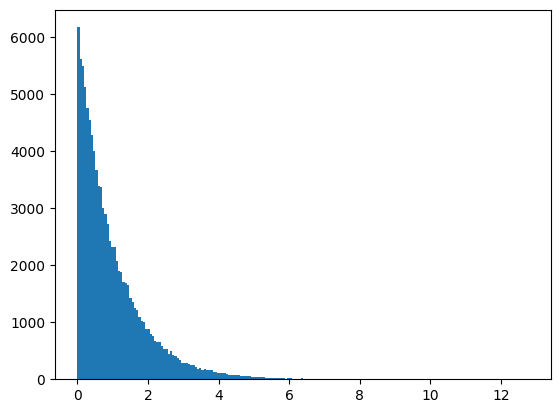

In [31]:
nrExperiments = 10
subSamples = []
m = 10
lambda_S = 1/8 #Time between services
lambda_A = 1 #Time between arrivals
k_S = 2.00

S_t = rngd.Exponential(lambda_S)
A_t = rngd.Exponential(lambda_A)

arrival_sample_for_plot = A_t.getSample(100000)
plt.hist(arrival_sample_for_plot,bins=200)
print("")

Y = []

for i in range(nrExperiments):


    servers = ds.BlockingServers(S_t,m)

    nrArrivals = 10*1000

    t = 0
    event_list = []
    Y_i = []
    for i in range(nrArrivals):
        sample_time = A_t.getSample()[0]
        t += sample_time
        Y_i += [sample_time]
        event_list += [t]

    blockingCounter = []

    for t_A in event_list:
        blockingCounter += [(t_A,servers.scheduleService(t_A))]

    subSamples += [blockingCounter]
    Y += [Y_i]


proportions = ds.getSubProportions(subSamples)
Z = []

for i,Yi in enumerate(Y):
    Z += vr.controlVariable(proportions[i],np.mean(Yi),lambda_A)


CI = ds.getConfidenceInterval(proportions)

print(f"Blocked C.I: {CI}\t Nr accepted in first run: {ds.getNrBlocked(subSamples[0]).count(0)}")

# Exercise 5 Task 6)

a) Arrival times

It is not possible to write our arrival times sampling in the form of $G_1(U_1, U_2 ,...)$ and $G_1(U_1, U_2 ,...)$, because we use 2 random numbers per arrival time in the hyperexponential case.

Instead, we decide to generate a new u for deciding which exponential distribution to use in the hyperexponential and then use the same U to generate the exponentially distributed arrival time in both systems. This way, we ensure, that when the first exponential distribution is high, the second is also high (relative to the distribution that was chosen,) thereby comparing the two more equally.

b) Processing Times

We create a second set of randomly generated numbers that we use in both systems to draw processing times

Finally we get a variance much smaller than 1 between the two systems.

In [40]:
nrExperiments = 10
nrArrivals = 10*1000

U = [np.random.uniform(0,1,nrArrivals*5) for x in range(nrExperiments)]
U_A = [np.random.uniform(0,1,nrArrivals*5) for x in range(nrExperiments)]

S_t1 = rngd.Exponential(lambda_S)
S_t2 = rngd.MixtureModel([(0.8,rngd.Exponential(0.8333)),(0.2,rngd.Exponential(5.0))])

A_t = rngd.Exponential(lambda_A)

S1 = [rngd.PredefinedModel(S_t1.getSampleU(U[i])) for i in range(nrExperiments)]
S2 = [rngd.PredefinedModel(S_t2.getSampleU(U[i])) for i in range(nrExperiments)]

In [41]:
A = [rngd.PredefinedModel(A_t.getSampleU(U_A[i])) for i in range(nrExperiments)]


Blocked C.I: [0.11795835945743974, 0.12742164054256028]	 Nr accepted in first run: 8702


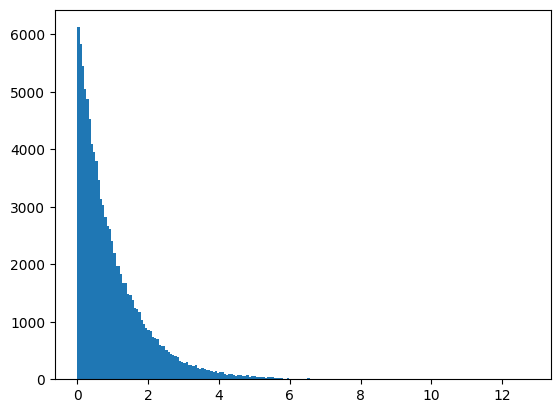

In [42]:

subSamples = []
m = 10
lambda_S = 1/8 #Time between services
lambda_A = 1 #Time between arrivals
k_S = 2.00



arrival_sample_for_plot = A_t.getSample(100000)
plt.hist(arrival_sample_for_plot,bins=200)
print("")

Y = []

for i in range(nrExperiments):


    servers = ds.BlockingServers(S1[i],m)


    t = 0
    event_list = []
    Y_i = []
    for j in range(nrArrivals):
        sample_time = A[i].getSample()[0]
        t += sample_time
        Y_i += [sample_time]
        event_list += [t]

    blockingCounter = []

    for t_A in event_list:
        blockingCounter += [(t_A,servers.scheduleService(t_A))]

    subSamples += [blockingCounter]
    Y += [Y_i]


proportions_1 = ds.getSubProportions(subSamples)

CI = ds.getConfidenceInterval(proportions)

print(f"Blocked C.I: {CI}\t Nr accepted in first run: {ds.getNrBlocked(subSamples[0]).count(0)}")

In [43]:
A = [rngd.PredefinedModel(A_t.getSampleU(U_A[i])) for i in range(nrExperiments)]


Blocked C.I: [0.11795835945743974, 0.12742164054256028]	 Nr accepted in first run: 10000


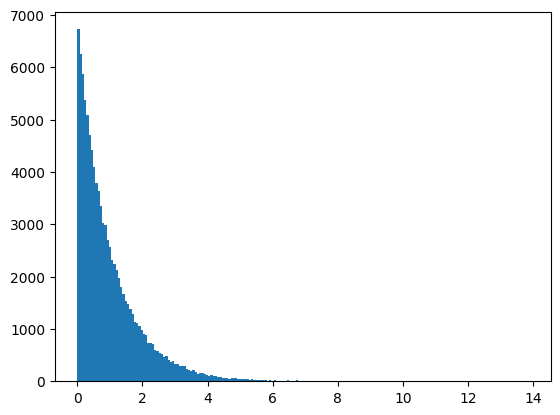

In [44]:

subSamples = []
m = 10
lambda_S = 1/8 #Time between services
lambda_A = 1 #Time between arrivals
k_S = 2.00



arrival_sample_for_plot = A_t.getSample(100000)
plt.hist(arrival_sample_for_plot,bins=200)
print("")

Y = []

for i in range(nrExperiments):


    servers = ds.BlockingServers(S2[i],m)


    t = 0
    event_list = []
    Y_i = []
    for j in range(nrArrivals):
        sample_time = A[i].getSample()[0]
        t += sample_time
        Y_i += [sample_time]
        event_list += [t]

    blockingCounter = []

    for t_A in event_list:
        blockingCounter += [(t_A,servers.scheduleService(t_A))]

    subSamples += [blockingCounter]
    Y += [Y_i]


proportions_2 = ds.getSubProportions(subSamples)

CI = ds.getConfidenceInterval(proportions)

print(f"Blocked C.I: {CI}\t Nr accepted in first run: {ds.getNrBlocked(subSamples[0]).count(0)}")

In [45]:
print(np.var(np.array(proportions_2) - np.array(proportions_1)))

1.3260900000000009e-05


# Exercise 5 Task 7)

We would like to calculate

$P(Z>a) = \int_{-\infty}^{\infty} f(x) I_{x>a} dx = E[Z>a]$

This is approximated by sampling from a normal distribution and calculating the proportion of values above a.

We can see, that we approximate the true value quite well, as we get a total of 5% of the mass being above and below 1.96 standard deviations from the mean for $\sigma = 1$.

But the higher we raise $\sigma$ the further away we are from the true distribution. This is expected, as for low variance, if we sample a value and put a certain range around it with a given size, we're bound to capture a bigger part of the variation in values relative to their percentage of occuring, than with a high variance.

I.e the values are more clustered together for smaller $\sigma$.

In [46]:
Z_samples = 10000
sigma = 1
Z = np.random.normal(0,sigma*sigma,Z_samples)
for a in [-1.96*sigma,0,1.96*sigma]:
    print(f"Probability of getting Z>{a}: {(Z > a).sum()/Z_samples}")

Probability of getting Z>-1.96: 0.9734
Probability of getting Z>0: 0.5032
Probability of getting Z>1.96: 0.0259


# Exercise Task 8)

We start by solving for the variance of $Z = \frac{h(X)f(X)}{g(X)}$ and then we derive a numerical solution for the minimum.

$Var[\frac{h(X)f(X)}{g(X)}] = E_G[(\frac{h(X)f(X)}{g(X)})^2] - E_G[\frac{h(X)f(X)}{g(X)}]^2$

As $h(X) = I_{0<=x<=1}$ we get that the integral goes from 0 to 1

$E_G[(\frac{h(X)f(X)}{g(X)})^2] = \int_{0}^{1} \frac{e^{2x(\lambda + 1)}}{\lambda^2} dx - (\int_{0}^{1} \frac{e^{x(\lambda + 1)}}{\lambda} dx)^2$

Which results in

$Var[Z] = \frac{-1 + e^{\lambda+2}}{(\lambda + 2)\lambda} - (-1 + e)^2$

Solving for $\lambda$ numerically we arrive at: $\lambda \approx 1.35$

Best lambda value: 1.3547554755475548


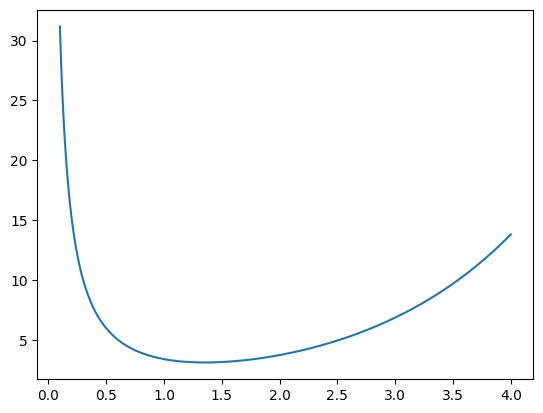

In [47]:
from scipy.optimize import minimize
_lambda = np.linspace(0.1,4,10000)
V_Z_left = (-1 + np.exp(_lambda + 2))/((_lambda +2)*_lambda)
V_Z_right = ((-1+np.exp(1))**2)
V_Z = V_Z_left - V_Z_right
plt.plot(_lambda,V_Z)
print(f"Best lambda value: {_lambda[np.argmin(V_Z)]}")

## Exercise 5 Task 9)

We have that

$\Theta = E[h(X)] =  E[ \frac{h(Y)f(Y)}{g(Y)} ]$
If we let $h(X) = X$ we get $E[h(X)] = E[X]$.

Solving for this, we get

$E[ \frac{h(Y)f(Y)}{g(Y)} ] = E[E[X]]$ which tells us, that the expectation is the expectation of the expectation, which is just the expectation, since the expectation is a constant, and the expectation of a constant is the constant itself, which in this case, is the expectation.

This conclusion whether or not this is meaningful is clearly no; In order to sample from the expectation, we would need the expectation to begin with.

It could be done in general, if we generally speaking have the expectation beforehand.


## Task 9 - part 2 - Related to question 8)

What we can do is set $g(x) = \frac{e^{x}}{E[X]}$

Putting this into the equation

$\Theta = E[I_{0<=x<=1}] =  E_g[ \frac{I_{0<=x<=1}e^{x}E[X]}{e^{x}} ]$

We know that $E[X] = 1$ so we have

$\Theta = \int_{0}^{1} \frac{e^{x}}{e^{x}} \times \frac{e^{x}}{E[X]} dx $

Which finally equals our wanted integral:

$\Theta = \int_{0}^{1} e^{x} dx$

Much more importantly, we see that the variance of the following expression equals 0:

$Var[\frac{h(Y)f(Y)}{g(Y)} ] = Var[1] = 0$